This notebook contains all the code and steps used to generate the figures for the simulations section of our Hierarchical Bootstrap paper. One may rerun the analysis to generate the figures for themselves or adapt the code presented here for their specific purposes.

In [1]:
#Import relevant libraries:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

Some of the most important functions that are used as part of these simulations are defined here. We begin with a bootstrapping function over two levels of data and then a function that can compute the pboot value between two populations of bootstrapped samples.

In [2]:
def get_bootstrapped_sample(variable,nboot=1000):
    '''
    This function performs a hierarchical bootstrap on the data present in 'variable'.
    This function assumes that the data in 'variable' is in the format of a 2D array where
    the rows represent the higher level (in this case, each row is a separate neuron) and
    the number of columns represent repetitions within that level (trials).
    '''
    bootstats = np.zeros(nboot)
    for i in np.arange(nboot):
        temp = []
        num_lev1 = np.shape(variable)[0]
        num_lev2 = np.shape(variable)[1]
        rand_lev1 = np.random.choice(num_lev1,num_lev1)
        for j in rand_lev1:
            rand_lev2 = np.random.choice(num_lev2,num_lev2)
            temp.append(variable[j,rand_lev2])
        
        #Note that this is the step at which actual computation is performed. In all cases for these simulations
        #we are only interested in the mean. But as elaborated in the text, this method can be extended to 
        #several other metrics of interest. They would be computed here:
        bootstats[i] = np.mean(temp)
        
    return bootstats

In [3]:
def get_direct_prob(sample1, sample2):
    '''
    get_direct_prob Returns the direct probability of items from sample2 being
    greater than or equal to those from sample1.
       Sample1 and Sample2 are two bootstrapped samples and this function
       directly computes the probability of items from sample 2 being greater
       than or equal to those from sample1. Since the bootstrapped samples are
       themselves posterior distributions, this is a way of computing a
       Bayesian probability. The joint matrix can also be returned to compute
       directly upon.
    '''
    joint_low_val = min([min(sample1),min(sample2)])
    joint_high_val = max([max(sample1),max(sample2)])
    
    p_joint_matrix = np.zeros((100,100))
    p_axis = np.linspace(joint_low_val,joint_high_val,num=100)
    edge_shift = (p_axis[2] - p_axis[1])/2
    p_axis_edges = p_axis - edge_shift
    p_axis_edges = np.append(p_axis_edges, (joint_high_val + edge_shift))

    #Calculate probabilities using histcounts for edges.

    p_sample1 = np.histogram(sample1,bins=p_axis_edges)[0]/np.size(sample1)
    p_sample2 = np.histogram(sample2,bins=p_axis_edges)[0]/np.size(sample2)

    #Now, calculate the joint probability matrix:

    for i in np.arange(np.shape(p_joint_matrix)[0]):
        for j in np.arange(np.shape(p_joint_matrix)[1]):
            p_joint_matrix[i,j] = p_sample1[i]*p_sample2[j]
            
    #Normalize the joint probability matrix:
    p_joint_matrix = p_joint_matrix/np.sum(p_joint_matrix)
    
    #Get the volume of the joint probability matrix in the upper triangle:
    p_test = np.sum(np.triu(p_joint_matrix))
    
    return p_test, p_joint_matrix

# Data generation and problem setup:

For our first experiment, we want to see what happens when we simulate 1000 neurons each recorded for a 100 trials at a firing rate of 5 Hz. We will then randomly split these neurons into two groups of 500 neurons each and compare the mean firing rates between the two groups. They should not be different from each other.

In [4]:
np.random.seed(1234)
neurons = np.random.poisson(lam=5.0,size=(100,1000)) #Size is 100 trials each for 1000 neurons
neurons = np.transpose(neurons) #Easier to understand rows as neurons and columns as trials

In [5]:
np.shape(neurons)

(1000, 100)

## Run the Experiment:

In [6]:
def get_simulated_results(sim_data):
    #Set simulation run parameters here: (For Fig 1, set to 10000; for Fig 2, set to 1000)
    n_runs = 1000
    
    #Define variables in which results will be saved:
    results = np.zeros((n_runs,3)) #3 columns for p-values from traditional, summarized and bootstrapped
    sem_results = np.zeros((n_runs,6)) #6 columns for SEMs similarly since each has SEM for low and high rates
    num_lev1 = np.shape(sim_data)[0]
    assert num_lev1 % 2 == 0, "Number of values in level 1 is not even"
    num_lev2 = np.shape(sim_data)[1]
    
    #Repeat the experiment for n_runs times:
    for i in np.arange(n_runs):
        #Randomly permute the neurons assigned to each group and split them.
        ind = np.random.permutation(num_lev1)
        low_data = sim_data[ind[0:int(num_lev1/2)]]
        high_data = sim_data[ind[int(num_lev1/2):]]
        
        #Get t-statistic p-value for traditional calculation:
        results[i,0] = stats.ttest_ind(np.ravel(low_data),np.ravel(high_data))[1]
        #Get SEMs for the same:
        sem_results[i,0] = np.std(low_data)/np.sqrt(np.size(low_data))
        sem_results[i,1] = np.std(high_data)/np.sqrt(np.size(high_data))
        
        low_means = np.mean(low_data,1)
        high_means = np.mean(high_data,1)
        
        #Get t-statistic p-value for summarized calculation:
        results[i,1] = stats.ttest_ind(low_means,high_means)[1]
        #Get SEMs for the same:
        sem_results[i,2] = np.std(low_means)/np.sqrt(np.size(low_means))
        sem_results[i,3] = np.std(high_means)/np.sqrt(np.size(high_means))
        
        #Now calculate bootstrapped samples:
        bootstats1 = get_bootstrapped_sample(low_data)
        bootstats2 = get_bootstrapped_sample(high_data)
        
        #Calculate probability of bootstats2 >= bootstats1:
        results[i,2] = get_direct_prob(bootstats1,bootstats2)[0]
        #Get SEM from bootstrapped samples:
        sem_results[i,4] = np.std(bootstats1)
        sem_results[i,5] = np.std(bootstats2)
        
        print("Run {} completed".format(i))
        
    return results, sem_results

In [ ]:
#This code may take a while to run. For speed, the results were saved after running once and subsequently loaded
#into the cells below:
results = get_simulated_results(neurons)
sem_results = results[1]
results = results[0]

#Get the proportion of significant differences:
prop_of_sig_results = np.zeros(3)
prop_of_sig_results[0] = np.sum(results[:,0]<0.05)/np.size(results[:,0])
prop_of_sig_results[1] = np.sum(results[:,1]<0.05)/np.size(results[:,1])
prop_of_sig_results[2] = np.sum((results[:,2]<0.05) | (results[:,2]>0.95))/np.size(results[:,0])

#Save the measures of the SEM:
sem_summaries = np.zeros(6)
sem_summaries[0] = np.mean(sem_results[:,:2])
sem_summaries[1] = np.std(sem_results[:,:2])
sem_summaries[2] = np.mean(sem_results[:,2:4])
sem_summaries[3] = np.std(sem_results[:,2:4])
sem_summaries[4] = np.mean(sem_results[:,4:])
sem_summaries[5] = np.std(sem_results[:,4:])

#We save and load the results since the simulations take over 24 hours to run for 10000 runs
np.savetxt('sig_results_fig_1.csv',prop_of_sig_results,delimiter=',')
np.savetxt('sem_summaries_fig_1.csv',sem_summaries,delimiter=',')
np.savetxt('pvalues_full_fig_1.csv',results,delimiter=',')

In [7]:
#Load the saved values into the corresponding variable names:
prop_of_sig_results = np.loadtxt('sig_results_fig_1.csv',delimiter=',')
sem_summaries = np.loadtxt('sem_summaries_fig_1.csv',delimiter = ',')
results = np.loadtxt('pvalues_full_fig_1.csv',delimiter=',')

In [8]:
#Include alpha = 5% for bootstrapping procedure to proportion of significant results:
prop_of_sig_results = np.append(prop_of_sig_results,np.sum((results[:,2]<0.025) | (results[:,2]>0.975))/np.size(results[:,0]))

In [9]:
#In order to get the error bars on the proportion of significant results, we can again bootstrap:
prop_of_sig_results_error_bars = np.zeros(np.shape(prop_of_sig_results))
prop_of_sig_results_diff_5 = np.zeros(np.shape(prop_of_sig_results))

nboot = 10000
bootstats1 = np.zeros(nboot)
bootstats2 = np.zeros(nboot)
bootstats3 = np.zeros(nboot)
bootstats4 = np.zeros(nboot)
np.random.seed(1234) #For reproducibility since this is used for stats tests

for n in np.arange(nboot):
    num_lev = np.shape(results)[0]
    rand_lev = np.random.choice(num_lev,num_lev)
    temp = results[rand_lev,:]
    
    bootstats1[n] = np.sum(temp[:,0]<0.05)/np.size(temp[:,0])
    bootstats2[n] = np.sum(temp[:,1]<0.05)/np.size(temp[:,1])
    bootstats3[n] = np.sum((temp[:,2]<0.05) | (temp[:,2]>0.95))/np.size(temp[:,2])
    bootstats4[n] = np.sum((temp[:,2]<0.025) | (temp[:,2]>0.975))/np.size(temp[:,2])

prop_of_sig_results_error_bars[0] = np.std(bootstats1)
prop_of_sig_results_error_bars[1] = np.std(bootstats2)
prop_of_sig_results_error_bars[2] = np.std(bootstats3)
prop_of_sig_results_error_bars[3] = np.std(bootstats4)

In [10]:
#We can then compute if the distributions are significantly different from the expected 5% false positive rate:
prop_of_sig_results_diff_5[0] = np.sum(bootstats1 >= 0.05)/np.size(bootstats1)
prop_of_sig_results_diff_5[1] = np.sum(bootstats2 >= 0.05)/np.size(bootstats2)
prop_of_sig_results_diff_5[2] = np.sum(bootstats3 >= 0.05)/np.size(bootstats3)
prop_of_sig_results_diff_5[3] = np.sum(bootstats4 >= 0.05)/np.size(bootstats4)

prop_of_sig_results_diff_5

array([0.2623, 0.4161, 0.    , 0.    ])

As shown above, while the Traditional and Summarized methods are not different from 5%, the bootstrap is for both alpha = 5% and even alpha = 10%.

<IPython.core.display.Javascript object>


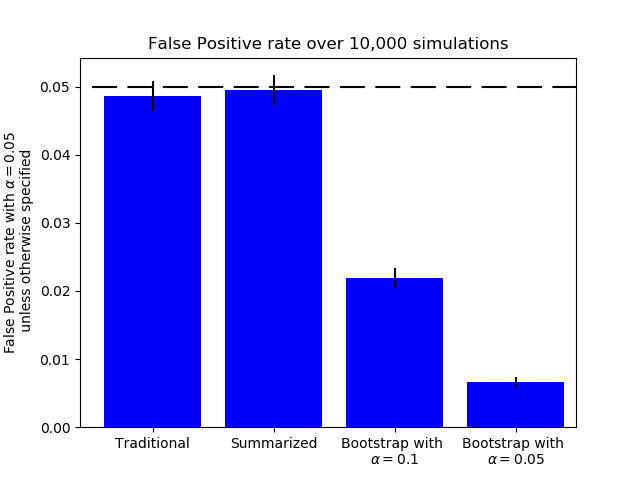

Text(0.5, 1.0, 'False Positive rate over 10,000 simulations')

In [11]:
#Figure 3a in paper:

%matplotlib notebook
index = np.arange(len(prop_of_sig_results))
alpha = 0.05*np.ones(np.shape(index))
plt.bar(index,prop_of_sig_results,color='b',yerr=prop_of_sig_results_error_bars)
plt.plot([-0.5, 3.5],[0.05, 0.05],color='k',dashes=[12,5],label = '5% level')
labels = ['Traditional', 'Summarized','Bootstrap with \n' r'$\alpha = 0.1$', 'Bootstrap with \n' r'$\alpha = 0.05$']
plt.xticks(index,labels)
plt.xlim([-0.6,3.5])
plt.ylabel('False Positive rate with 'r'$\alpha = 0.05$' '\n unless otherwise specified')
plt.title('False Positive rate over 10,000 simulations')

<IPython.core.display.Javascript object>


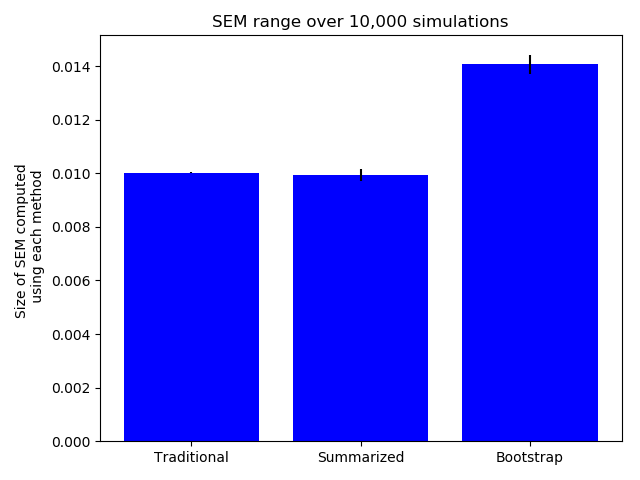

In [12]:
#Figure 3b in paper:

index = np.arange(3)
plt.bar(index,sem_summaries[[0,2,4]],color='b',yerr=sem_summaries[[1,3,5]])
labels = ['Traditional', 'Summarized', 'Bootstrap']
plt.xticks(index,labels)
plt.ylabel('Size of SEM computed \n using each method')
plt.title('SEM range over 10,000 simulations')
plt.tight_layout()

# Fig 2 - conservative bias when data points are not independent

In the above example, since the variance was the same between levels, all the datapoints were still independent in spite of the hierarchical structure. Here, we will make the points non-independent by adding Gaussian noise to the mean firing rates of each neuron without changing the firing rate across trials. We will also test the effect of varying the number of trials on the false positive rate.

In [ ]:
#This simulation too takes a while to run. Hence, the same strategy as before has been deployed:
np.random.seed(1234) #Seed for reproducibility.
firing_rate = 5
num_trials = [10, 30, 100, 300, 1000, 3000]
num_runs = len(num_trials)

prop_of_sig_results = np.zeros((num_runs,3))
sem_summaries = np.zeros((num_runs,6))
prop_of_sig_results_error_bars = np.zeros(np.shape(prop_of_sig_results))
prop_of_sig_results_diff_5 = np.zeros(np.shape(prop_of_sig_results))

run = 0

for trials in num_trials:
    neurons = np.zeros((1000,trials))
    num_lev1 = np.shape(neurons)[0]
    num_lev2 = np.shape(neurons)[1]
    for i in np.arange(num_lev1):
        f_rate = firing_rate + 3*np.random.normal(0,1)
        if f_rate < 0:
            f_rate = 0.01
        neurons[i,:] = np.random.poisson(lam=f_rate,size=(1,trials))
            
    results, sem_results = get_simulated_results(neurons)
    
    prop_of_sig_results[run,0] = np.sum(results[:,0]<0.05)/np.size(results[:,0])
    prop_of_sig_results[run,1] = np.sum(results[:,1]<0.05)/np.size(results[:,1])
    prop_of_sig_results[run,2] = np.sum((results[:,2]<0.025) | (results[:,2]>0.975))/np.size(results[:,0])
    
    sem_summaries[run,0] = np.mean(sem_results[:,:2])
    sem_summaries[run,1] = np.std(sem_results[:,:2])
    sem_summaries[run,2] = np.mean(sem_results[:,2:4])
    sem_summaries[run,3] = np.std(sem_results[:,2:4])
    sem_summaries[run,4] = np.mean(sem_results[:,4:])
    sem_summaries[run,5] = np.std(sem_results[:,4:])
    
    nboot = 10000
    bootstats1 = np.zeros(nboot)
    bootstats2 = np.zeros(nboot)
    bootstats3 = np.zeros(nboot)

    for n in np.arange(nboot):
        num_lev = np.shape(results)[0]
        rand_lev = np.random.choice(num_lev,num_lev)
        temp = results[rand_lev,:]

        bootstats1[n] = np.sum(temp[:,0]<0.05)/np.size(temp[:,0])
        bootstats2[n] = np.sum(temp[:,1]<0.05)/np.size(temp[:,1])
        bootstats3[n] = np.sum((temp[:,2]<0.025) | (temp[:,2]>0.975))/np.size(temp[:,2])

    prop_of_sig_results_error_bars[run,0] = np.std(bootstats1)
    prop_of_sig_results_error_bars[run,1] = np.std(bootstats2)
    prop_of_sig_results_error_bars[run,2] = np.std(bootstats3)
    
    prop_of_sig_results_diff_5[run,0] = np.sum(bootstats1 >= 0.05)/np.size(bootstats1)
    prop_of_sig_results_diff_5[run,1] = np.sum(bootstats2 >= 0.05)/np.size(bootstats2)
    prop_of_sig_results_diff_5[run,2] = np.sum(bootstats3 >= 0.05)/np.size(bootstats3)
    
    print("Finished simulations for {} number of trials".format(trials))
    
    run = run+1

In [ ]:
#We save and load the results since the simulations take over 24 hours to run for 10000 runs
np.savetxt('sig_results_fig_2.csv',prop_of_sig_results,delimiter=',')
np.savetxt('sem_summaries_fig_2.csv',sem_summaries,delimiter=',')
np.savetxt('sig_error_bars_fig_2.csv',prop_of_sig_results_error_bars,delimiter=',')
np.savetxt('sig_diff_5_fig_2.csv',prop_of_sig_results_diff_5,delimiter=',')

In [13]:
#Produce figures:
prop_of_sig_results = np.loadtxt('sig_results_fig_2.csv',delimiter=',')
sem_summaries = np.loadtxt('sem_summaries_fig_2.csv',delimiter = ',')
prop_of_sig_results_error_bars = np.loadtxt('sig_error_bars_fig_2.csv',delimiter=',')

<IPython.core.display.Javascript object>


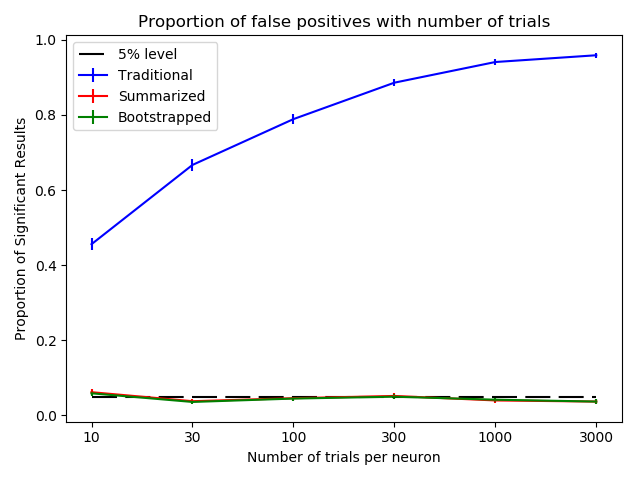

In [16]:
#Figure 2a in paper:

num_trials = [10, 30, 100, 300, 1000, 3000]
num_groups = len(num_trials)

index = np.arange(num_groups)
alpha = 0.05*np.ones(np.shape(index))
bar_width = 0.1

plt.errorbar(index, prop_of_sig_results[:,0],
        yerr=prop_of_sig_results_error_bars[:,0], color='b', label='Traditional')

plt.errorbar(index , prop_of_sig_results[:,1],
        yerr=prop_of_sig_results_error_bars[:,1], color='r', label='Summarized')

plt.errorbar(index, prop_of_sig_results[:,2],
        yerr=prop_of_sig_results_error_bars[:,2], color='g', label='Bootstrapped')

plt.plot(index,alpha,color='k',dashes=[12,4],label = '5% level')

plt.xlabel('Number of trials per neuron')
plt.ylabel('Proportion of Significant Results')
plt.title('Proportion of false positives with number of trials')
plt.xticks(index,num_trials)
plt.legend()
plt.tight_layout()

<IPython.core.display.Javascript object>


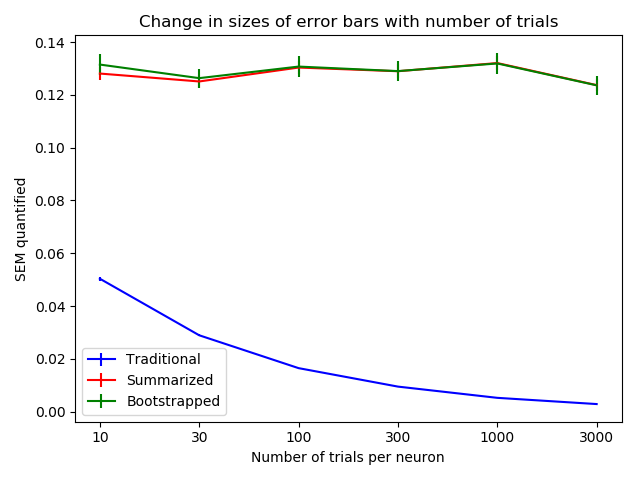

In [17]:
#Figure 2b in paper:

index = np.arange(num_groups)

plt.errorbar(index, sem_summaries[:,0], yerr=sem_summaries[:,1],
        color='b', label='Traditional')

plt.errorbar(index, sem_summaries[:,2], yerr=sem_summaries[:,3],
        color='r', label='Summarized')

plt.errorbar(index, sem_summaries[:,4], yerr=sem_summaries[:,5],
        color='g', label='Bootstrapped')

plt.xlabel('Number of trials per neuron')
plt.ylabel('SEM quantified')
plt.title('Change in sizes of error bars with number of trials')
plt.xticks(index, num_trials)
plt.legend()

plt.tight_layout()

## Fig 4 - the effects on statistical power:

Power is defined as 1 - the false negative rate beta. Therefore, in order to compute power, we need to have a situation in which there is a statistical difference between groups. And we need to compute the fraction of times that difference is not detected by the various methods.

In order to do this, let us once again use our example of neuron firing. Let us now have two groups of neurons, one with a mean firing rate of 5Hz and the other with a mean firing rate of 5 + Delta Hz where Delta is a measure of the effect size and Delta varys as 0, 1.5, 3, 4.5 Hz respectively. Additionally, let us study the effect of varying the number of neurons in each group keeping the number of trials constant.

In [18]:
def get_simulated_results(firing_rate1,firing_rate2,neurons):
    #Set simulation run parameters here:
    n_runs = 1000
    
    low_data = np.zeros((neurons,100))
    high_data = np.zeros((neurons,100))
    num_lev1 = np.shape(low_data)[0]
    num_lev2 = np.shape(low_data)[1]
    
    #Define variables in which results will be saved:
    results = np.zeros((n_runs,3)) #3 columns for p-values from traditional, summarized and bootstrapped
    sem_results = np.zeros((n_runs,6)) #6 columns for SEMs similarly since each has SEM for low and high rates
    
    #Repeat the experiment for n_runs times:
    for i in np.arange(n_runs):
        for n in np.arange(num_lev1):
            f_rate1 = firing_rate1 + 3*np.random.normal(0,1)
            if f_rate1 < 0:
                f_rate1 = 0.01
            low_data[n,:] = np.random.poisson(lam=f_rate1,size=(1,100))
            f_rate2 = firing_rate2 + 3*np.random.normal(0,1)
            if f_rate2 < 0:
                f_rate2 = 0.01
            high_data[n,:] = np.random.poisson(lam=f_rate2,size=(1,100))
        
        #Get t-statistic p-value for traditional calculation:
        results[i,0] = stats.ttest_ind(np.ravel(low_data),np.ravel(high_data))[1]
        #Get SEMs for the same:
        sem_results[i,0] = np.std(low_data)/np.sqrt(np.size(low_data))
        sem_results[i,1] = np.std(high_data)/np.sqrt(np.size(high_data))
        
        low_means = np.mean(low_data,1)
        high_means = np.mean(high_data,1)
        
        #Get t-statistic p-value for summarized calculation:
        results[i,1] = stats.ttest_ind(low_means,high_means)[1]
        #Get SEMs for the same:
        sem_results[i,2] = np.std(low_means)/np.sqrt(np.size(low_means))
        sem_results[i,3] = np.std(high_means)/np.sqrt(np.size(high_means))
        
        #Now calculate bootstrapped samples:
        bootstats1 = get_bootstrapped_sample(low_data)
        bootstats2 = get_bootstrapped_sample(high_data)
        
        #Calculate probability of bootstats2 >= bootstats1:
        results[i,2] = get_direct_prob(bootstats1,bootstats2)[0]
        #Get SEM from bootstrapped samples:
        sem_results[i,4] = np.std(bootstats1)
        sem_results[i,5] = np.std(bootstats2)
        
        print("Run {} completed".format(i))
        
    return results, sem_results

In [ ]:
#As before, simulation takes a long time to run:
np.random.seed(1234) #Seed for reproducibility.
firing_rate1 = 5
firing_rate2 = [5, 6.5, 8, 9.5] #The first run will give the false positive rate
num_neurons = np.arange(16) + 1
num_runs = len(num_neurons)
num_runs2 = len(firing_rate2)

prop_of_sig_results = np.zeros((num_runs,3,num_runs2))
sem_summaries = np.zeros((num_runs,6))
prop_of_sig_results_error_bars = np.zeros(np.shape(prop_of_sig_results))

run = 0
run2 = 0

for firing_rate in firing_rate2:
    for neurons in num_neurons:

        results, sem_results = get_simulated_results(firing_rate1, firing_rate, neurons)

        prop_of_sig_results[run,0,run2] = np.sum(results[:,0]<0.05)/np.size(results[:,0])
        prop_of_sig_results[run,1,run2] = np.sum(results[:,1]<0.05)/np.size(results[:,1])
        prop_of_sig_results[run,2,run2] = np.sum((results[:,2]<0.025) | (results[:,2]>0.975))/np.size(results[:,0])

        nboot = 10000
        bootstats1 = np.zeros(nboot)
        bootstats2 = np.zeros(nboot)
        bootstats3 = np.zeros(nboot)

        for n in np.arange(nboot):
            num_lev = np.shape(results)[0]
            rand_lev = np.random.choice(num_lev,num_lev)
            temp = results[rand_lev,:]

            bootstats1[n] = np.sum(temp[:,0]<0.05)/np.size(temp[:,0])
            bootstats2[n] = np.sum(temp[:,1]<0.05)/np.size(temp[:,1])
            bootstats3[n] = np.sum((temp[:,2]<0.025) | (temp[:,2]>0.975))/np.size(temp[:,2])

        prop_of_sig_results_error_bars[run,0,run2] = np.std(bootstats1)
        prop_of_sig_results_error_bars[run,1,run2] = np.std(bootstats2)
        prop_of_sig_results_error_bars[run,2,run2] = np.std(bootstats3)

        print("Finished simulations for {} number of neurons".format(neurons))

        run = run+1
        
    print("Finished simulations for {} firing rate".format(firing_rate))
    run2 = run2+1
    run = 0

In [ ]:
#In order to save, we need to convert the 3-D arrays to 2-D and reliably back:
np.savetxt('sig_results_power.csv', prop_of_sig_results.reshape(num_runs*num_runs2,3),delimiter=',')
np.savetxt('sig_results_error_bars_power.csv',prop_of_sig_results_error_bars.reshape(num_runs*num_runs2,3),delimiter=',')

In [19]:
#If they need to be loaded back, they will need to reshaped like so:
firing_rate1 = 5
firing_rate2 = [5, 6.5, 8, 9.5] #The first run will give the false positive rate
num_neurons = np.arange(16) + 1
num_runs = len(num_neurons)
num_runs2 = len(firing_rate2)
prop_of_sig_results = np.loadtxt('sig_results_power.csv',delimiter=',').reshape(num_runs,3,num_runs2)
prop_of_sig_results_error_bars = np.loadtxt('sig_results_error_bars_power.csv',delimiter=',').reshape(num_runs,3,num_runs2)

<IPython.core.display.Javascript object>


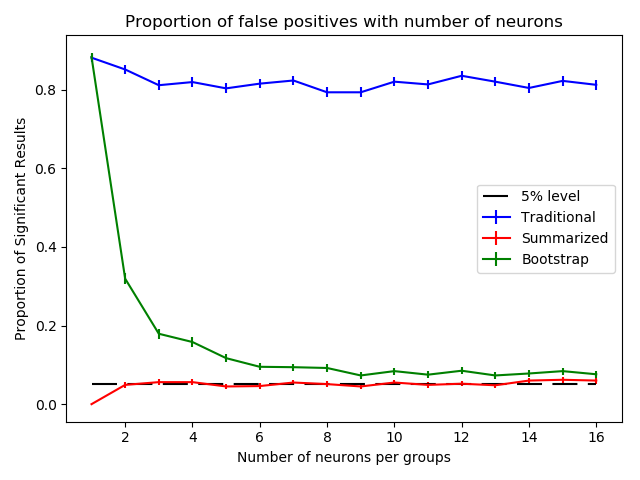

In [20]:
#Figure 4a in paper:

index = np.arange(16) + 1
#index = index[1:]
alpha = 0.05*np.ones(np.shape(index))

plt.errorbar(index,prop_of_sig_results[:,0,0],yerr = prop_of_sig_results_error_bars[:,0,0],
         color = 'b', label = 'Traditional')

plt.errorbar(index,prop_of_sig_results[:,1,0],yerr = prop_of_sig_results_error_bars[:,1,0],
         color = 'r', label = 'Summarized')

plt.errorbar(index,prop_of_sig_results[:,2,0],yerr = prop_of_sig_results_error_bars[:,2,0],
         color = 'g', label = 'Bootstrap')

plt.plot(index,alpha,color='k',dashes=[12,5],label = '5% level')

plt.xlabel('Number of neurons per groups')
plt.ylabel('Proportion of Significant Results')
plt.title('Proportion of false positives with number of neurons')
plt.legend()

plt.tight_layout()


<IPython.core.display.Javascript object>


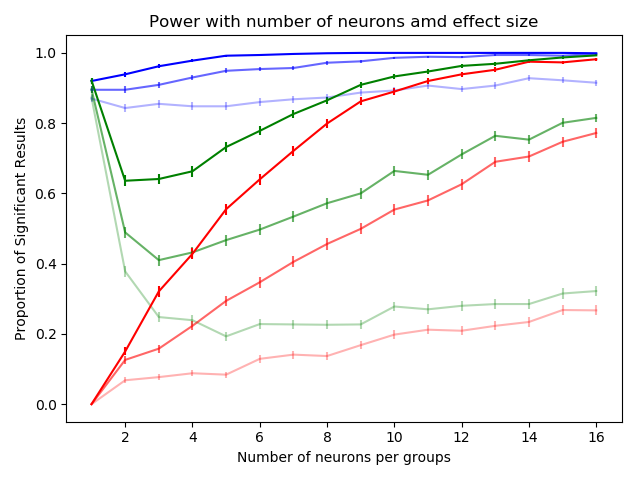

In [21]:
#Figure 4b in the paper:

alpha = 0.05*np.ones(np.shape(index))
opacity = [0.3,0.6,1]

plt.errorbar(index,prop_of_sig_results[:,0,1],yerr = prop_of_sig_results_error_bars[:,0,1],
         alpha = opacity[0], color = 'b', label = 'Traditional')

plt.errorbar(index,prop_of_sig_results[:,1,1],yerr = prop_of_sig_results_error_bars[:,1,1],
         alpha = opacity[0], color = 'r', label = 'Summarized')

plt.errorbar(index,prop_of_sig_results[:,2,1],yerr = prop_of_sig_results_error_bars[:,2,1],
         alpha = opacity[0], color = 'g', label = 'Bootstrap')

plt.errorbar(index,prop_of_sig_results[:,0,2],yerr = prop_of_sig_results_error_bars[:,0,2],
         alpha = opacity[1], color = 'b', label = 'Traditional')

plt.errorbar(index,prop_of_sig_results[:,1,2],yerr = prop_of_sig_results_error_bars[:,1,2],
         alpha = opacity[1], color = 'r', label = 'Summarized')

plt.errorbar(index,prop_of_sig_results[:,2,2],yerr = prop_of_sig_results_error_bars[:,2,2],
         alpha = opacity[1], color = 'g', label = 'Bootstrap')

plt.errorbar(index,prop_of_sig_results[:,0,3],yerr = prop_of_sig_results_error_bars[:,0,3],
         alpha = opacity[2], color = 'b', label = 'Traditional')

plt.errorbar(index,prop_of_sig_results[:,1,3],yerr = prop_of_sig_results_error_bars[:,1,3],
         alpha = opacity[2], color = 'r', label = 'Summarized')

plt.errorbar(index,prop_of_sig_results[:,2,3],yerr = prop_of_sig_results_error_bars[:,2,3],
         alpha = opacity[2], color = 'g', label = 'Bootstrap')

plt.xlabel('Number of neurons per groups')
plt.ylabel('Proportion of Significant Results')
plt.title('Power with number of neurons amd effect size')


plt.tight_layout()